# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [3]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(np.float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(np.float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [4]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1,-2,3],
              [-1, 2, 0.1]
              ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [5]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [6]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [7]:
# TODO Now implement l2 regularization in the forward and backward pass
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for W_out
Gradient check passed!
Checking gradient for W_in
Gradient check passed!
Checking gradient for B_out
Gradient check passed!
Checking gradient for B_in
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

**Ответ:** В среднем 0.1, поскольку сеть нетренирована. Флуктуации обеспечены рандомным распределением весов сети.

In [8]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
multiclass_accuracy(model_with_reg.predict(train_X[:30]), train_y[:30]) 

0.1

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [9]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.256525, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234411, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.218805, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299442, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250353, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.204378, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.344327, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.242054, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.280916, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.261553, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.259453, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301086, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.339098, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268823, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.367442, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.226122, Train acc

**Комментарий:** Уменьшил коэффициент регуляризации с 1e1 до 1e-1, поскольку функция потерь не уменьшалась.

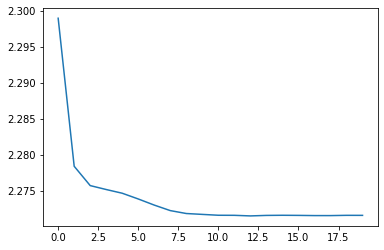

In [10]:
plt.plot(loss_history)

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [11]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.275985, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.347515, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264348, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287890, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.253264, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.265011, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.212698, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320777, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302624, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311032, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234316, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.283390, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.353994, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.217454, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.378711, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256101, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [12]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.322051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308033, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.317549, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.262630, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270323, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.308261, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264990, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278636, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267083, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.279901, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.276510, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314133, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.256404, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.295822, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.290051, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278750, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [13]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.351801, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319693, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.295926, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.345443, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.310013, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.326544, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.255641, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.199259, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.164561, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.025661, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.883798, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.263931, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.662918, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.245522, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.943906, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.663953, Train acc

Loss: 1.126413, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.008120, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.643235, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.592807, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.412599, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.212850, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.196541, Train accuracy: 0.933333, val accuracy: 0.000000
Loss: 1.280346, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.403204, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.229377, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.400568, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.391042, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.102808, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.445285, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.406323, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.219193, Train acc

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

**Комментарий**: Перед тем как устроить перебор по всей сетке параметров, подберем на глаз: поставим Momentum, увеличим число нейронов в скрытом слое, поставим не такую большую регуляризацию. В случае успеха не придется делать перебор.

UPD: Сработало.

In [14]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 300, reg = 1e-5)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-1, num_epochs=20, batch_size=10)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.308723, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.304107, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.261888, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.197640, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.000701, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.682325, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.603348, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.851231, Train accuracy: 0.466667, val accuracy: 0.000000
Loss: 2.122996, Train accuracy: 0.400000, val accuracy: 0.133333
Loss: 1.678297, Train accuracy: 0.533333, val accuracy: 0.000000
Loss: 1.986914, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.856270, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.380942, Train accuracy: 0.733333, val accuracy: 0.000000
Loss: 0.262060, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 0.821596, Train accuracy: 0.866667, val accuracy: 0.000000
Loss: 0.201604, Train acc

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [15]:
# Let's train the best one-hidden-layer network we can

# Best parameters for now are (0.78, 50, 25, 200, 0.9, 0.8, 0.001, 0.1)
# best_parameters = (val_history[len(val_history)-1], batch, epoch, laysize, decay, moment, reg, rate)

learning_rates = [1e-1, 1e-2]
reg_strength = [1e-3, 1e-5]
hidden_layer_sizes = [64, 128, 256]
batch_size = [64, 128]
num_epochs = 16

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

# TODO find the best hyperparameters to train the network
# Don't hesitate to add new values to the arrays above, perform experiments, use any tricks you want
# You should expect to get to at least 40% of valudation accuracy
# Save loss/train/history of the best classifier to the variables above
for lr in learning_rates:
    for rs in reg_strength:
        for ls in hidden_layer_sizes:
            for bs in batch_size:
                model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=ls, reg=rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=bs)
                temp_loss_history, temp_train_history, temp_val_history = trainer.fit()
                
                if temp_val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = temp_val_history[-1]
                    loss_history = temp_loss_history.copy()
                    train_history = temp_train_history.copy()
                    val_history = temp_val_history.copy()
    
print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.254306, Train accuracy: 0.331222, val accuracy: 0.328000
Loss: 2.126411, Train accuracy: 0.390778, val accuracy: 0.384000
Loss: 1.599023, Train accuracy: 0.571889, val accuracy: 0.563000
Loss: 1.760083, Train accuracy: 0.574556, val accuracy: 0.556000
Loss: 1.589157, Train accuracy: 0.608889, val accuracy: 0.595000
Loss: 1.722784, Train accuracy: 0.645889, val accuracy: 0.620000
Loss: 1.604754, Train accuracy: 0.604667, val accuracy: 0.580000
Loss: 1.350564, Train accuracy: 0.620778, val accuracy: 0.587000
Loss: 1.217317, Train accuracy: 0.656000, val accuracy: 0.634000
Loss: 1.455710, Train accuracy: 0.629111, val accuracy: 0.602000
Loss: 1.511602, Train accuracy: 0.628111, val accuracy: 0.609000
Loss: 1.824530, Train accuracy: 0.670667, val accuracy: 0.649000
Loss: 1.476099, Train accuracy: 0.647778, val accuracy: 0.621000
Loss: 1.855392, Train accuracy: 0.666778, val accuracy: 0.642000
Loss: 1.348010, Train accuracy: 0.648111, val accuracy: 0.643000
Loss: 1.547200, Train acc

Loss: 0.658248, Train accuracy: 0.753778, val accuracy: 0.666000
Loss: 1.927966, Train accuracy: 0.348222, val accuracy: 0.354000
Loss: 1.867780, Train accuracy: 0.556667, val accuracy: 0.552000
Loss: 0.892738, Train accuracy: 0.627889, val accuracy: 0.608000
Loss: 1.123378, Train accuracy: 0.620333, val accuracy: 0.592000
Loss: 0.961163, Train accuracy: 0.659333, val accuracy: 0.623000
Loss: 1.145410, Train accuracy: 0.690333, val accuracy: 0.642000
Loss: 1.186451, Train accuracy: 0.726667, val accuracy: 0.663000
Loss: 1.162200, Train accuracy: 0.689000, val accuracy: 0.639000
Loss: 0.867996, Train accuracy: 0.712444, val accuracy: 0.645000
Loss: 1.174919, Train accuracy: 0.744222, val accuracy: 0.678000
Loss: 0.612320, Train accuracy: 0.730667, val accuracy: 0.654000
Loss: 0.708881, Train accuracy: 0.766444, val accuracy: 0.694000
Loss: 0.933329, Train accuracy: 0.756667, val accuracy: 0.688000
Loss: 1.129005, Train accuracy: 0.761778, val accuracy: 0.671000
Loss: 1.248485, Train acc

Loss: 1.607930, Train accuracy: 0.510889, val accuracy: 0.513000
Loss: 1.541639, Train accuracy: 0.546667, val accuracy: 0.547000
Loss: 2.268879, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.239465, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.194430, Train accuracy: 0.205667, val accuracy: 0.217000
Loss: 2.073439, Train accuracy: 0.274667, val accuracy: 0.281000
Loss: 1.839943, Train accuracy: 0.347444, val accuracy: 0.354000
Loss: 1.824723, Train accuracy: 0.437444, val accuracy: 0.430000
Loss: 1.509918, Train accuracy: 0.482778, val accuracy: 0.486000
Loss: 1.198880, Train accuracy: 0.565778, val accuracy: 0.560000
Loss: 1.530526, Train accuracy: 0.605444, val accuracy: 0.598000
Loss: 1.390096, Train accuracy: 0.646667, val accuracy: 0.629000
Loss: 1.169891, Train accuracy: 0.670778, val accuracy: 0.660000
Loss: 1.320987, Train accuracy: 0.687333, val accuracy: 0.664000
Loss: 1.163398, Train accuracy: 0.702333, val accuracy: 0.683000
Loss: 1.033215, Train acc

Loss: 1.306147, Train accuracy: 0.533111, val accuracy: 0.528000
Loss: 1.324272, Train accuracy: 0.571667, val accuracy: 0.550000
Loss: 1.270970, Train accuracy: 0.597889, val accuracy: 0.579000
best validation accuracy achieved: 0.721000


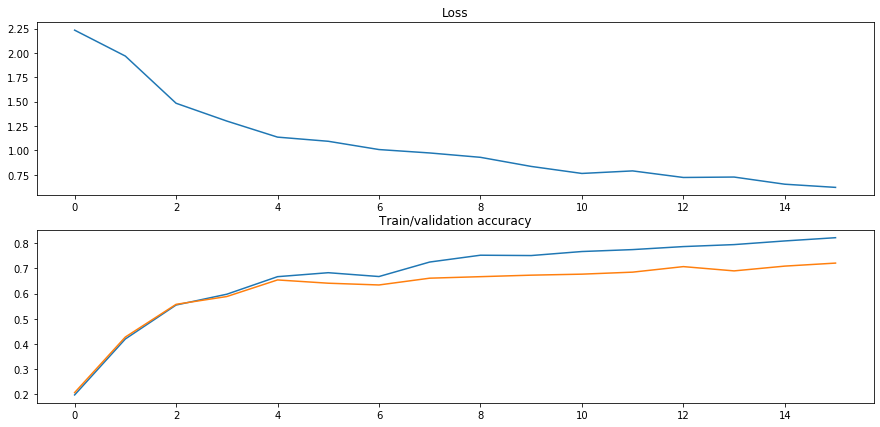

In [16]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [17]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.694000
